In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from neuropacks import BG
from pyuoi.linear_model import UoI_L1Logistic
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
gp_path = '/Users/psachdeva/data/berkes/IM-1015_170520_GP_v4.mat'
snr_path = '/Users/psachdeva/data/berkes/IM-1015_170520_SNr_rates_v4.mat'

In [3]:
gp = BG(gp_path)
snr = BG(snr_path)

# Predicting pre-tone failure

## Distribution of delays

In [6]:
preactive_success = gp.get_pre_tone_condition_trials(condition=True)
preactive_failure = gp.get_pre_tone_condition_trials(condition=False)

In [8]:
success_dts = np.zeros(preactive_success.size)
failure_dts = np.zeros(preactive_failure.size)

for idx, trial_idx in enumerate(preactive_success):
    trial = gp.trials[trial_idx]
    success_dts[idx] = trial.t_center_out - trial.t_center_in
    
for idx, trial_idx in enumerate(preactive_failure):
    trial = gp.trials[trial_idx]
    failure_dts[idx] = trial.t_center_out - trial.t_center_in

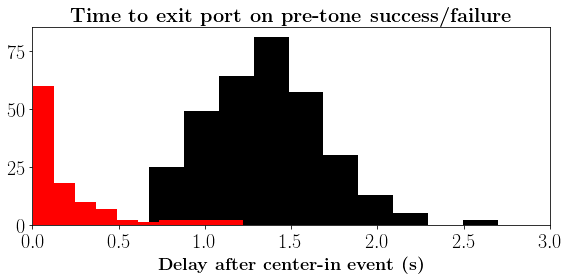

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(success_dts, color='k')
ax.hist(failure_dts, color='r')
ax.set_xlim([0, 3])
ax.set_xlabel(r'\textbf{Delay after center-in event (s)}', fontsize=18)
ax.set_title(r'\textbf{Time to exit port on pre-tone success/failure}', fontsize=20)
plt.tight_layout()
plt.savefig('delay_distribution_bg.pdf')

## Firing Rates in Pre-Tone Period

In [30]:
preactive_success = gp.get_pre_tone_condition_trials(condition=True)
preactive_failure = gp.get_pre_tone_condition_trials(condition=False)

In [40]:
sampling_rate = 500
window_length = 0.5
n_timestamps = int(sampling_rate * window_length - 1)
timestamps = np.arange(n_timestamps) / sampling_rate
sigma = 0.075

fr_success_gp = np.zeros((gp.n_good_units, preactive_success.size, n_timestamps))
fr_failure_gp = np.zeros((gp.n_good_units, preactive_failure.size, n_timestamps))
fr_success_snr = np.zeros((snr.n_good_units, preactive_success.size, n_timestamps))
fr_failure_snr = np.zeros((snr.n_good_units, preactive_failure.size, n_timestamps))

In [41]:
for ii, trial_idx in enumerate(preactive_success):
    trial = gp.trials[trial_idx]
    
    center_in = trial.t_center_in
    bounds = (center_in, center_in + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_success_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_success_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

In [42]:
for ii, trial_idx in enumerate(preactive_failure):
    trial = snr.trials[trial_idx]
    
    center_in = trial.t_center_in
    bounds = (center_in, center_in + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_failure_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_failure_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

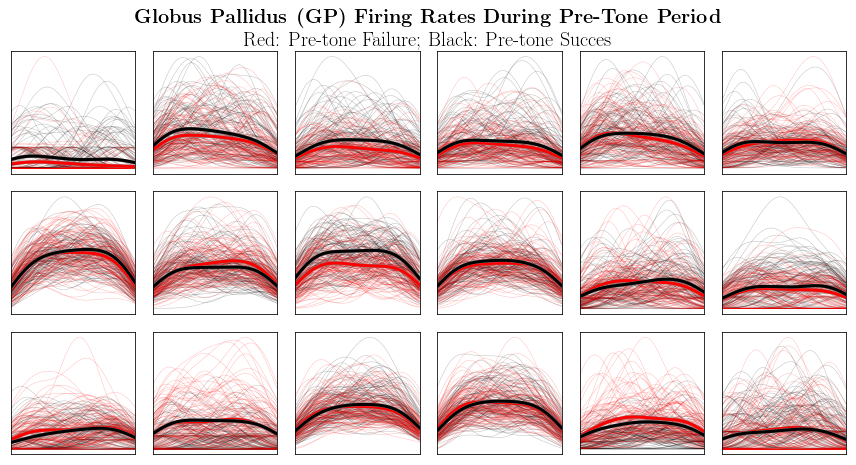

In [68]:
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_success_gp[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.25) for t_idx in range(fr_failure_gp.shape[1])]
    [ax.plot(timestamps, fr_failure_gp[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.25) for t_idx in range(fr_failure_gp.shape[1])]
    ax.plot(timestamps, np.mean(fr_failure_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_failure_gp[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_success_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_success_gp[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

fig.text(
    x=0.5, y=1.02, s=r'\textbf{Globus Pallidus (GP) Firing Rates During Pre-Tone Period}' '\n' r'Red: Pre-tone Failure; Black: Pre-tone Succes',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()
plt.savefig('gp_pretone_fr.pdf', bbox_inches='tight')
plt.show()

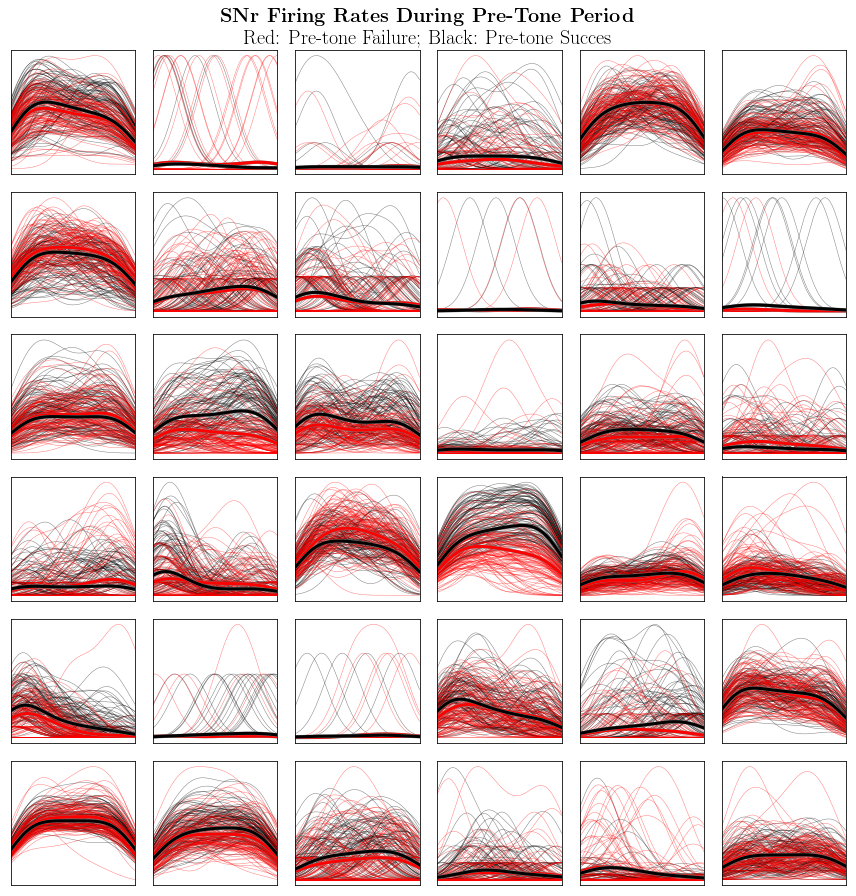

In [93]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_success_snr[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.5) for t_idx in range(fr_failure_snr.shape[1])]
    [ax.plot(timestamps, fr_failure_snr[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.5) for t_idx in range(fr_failure_snr.shape[1])]
    ax.plot(timestamps, np.mean(fr_failure_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_failure_snr[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_success_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_success_snr[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

    
fig.text(
    x=0.5, y=1.01, s=r'\textbf{SNr Firing Rates During Pre-Tone Period}' '\n' r'Red: Pre-tone Failure; Black: Pre-tone Succes',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()

plt.savefig('snr_pretone_fr.pdf', bbox_inches='tight')
plt.show()

## Logistic Regression in Pre-Tone Period

In [4]:
def idx_to_xy(idx, dx, dy):
    x = idx % dx
    y = dy - 1 - (idx // dx)
    return x, y

In [5]:
window_length = 0.50
n_folds = 5

lasso_gp_scores = np.zeros(n_folds)
lasso_gp_coefs = np.zeros((n_folds, gp.n_good_units))
uoi_gp_scores = np.zeros(n_folds)
uoi_gp_coefs = np.zeros((n_folds, gp.n_good_units))

lasso_snr_scores = np.zeros(n_folds)
lasso_snr_coefs = np.zeros((n_folds, snr.n_good_units))
uoi_snr_scores = np.zeros(n_folds)
uoi_snr_coefs = np.zeros((n_folds, snr.n_good_units))

In [90]:
X = np.zeros((gp.n_good_trials, gp.n_good_units))
y = np.zeros(gp.n_good_trials)

for t_idx, trial_idx in enumerate(gp.good_trials):
    trial = gp.trials[trial_idx]
    y[t_idx] = trial.is_pretone_success()
    
    t_center_in = trial.t_center_in
    
    for u_idx, unit_idx in enumerate(gp.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_in) & (spike_times <= t_center_in + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=10000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_gp_coefs[fold] = logistic.coef_
    lasso_gp_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=100,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=10000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_gp_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_gp_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

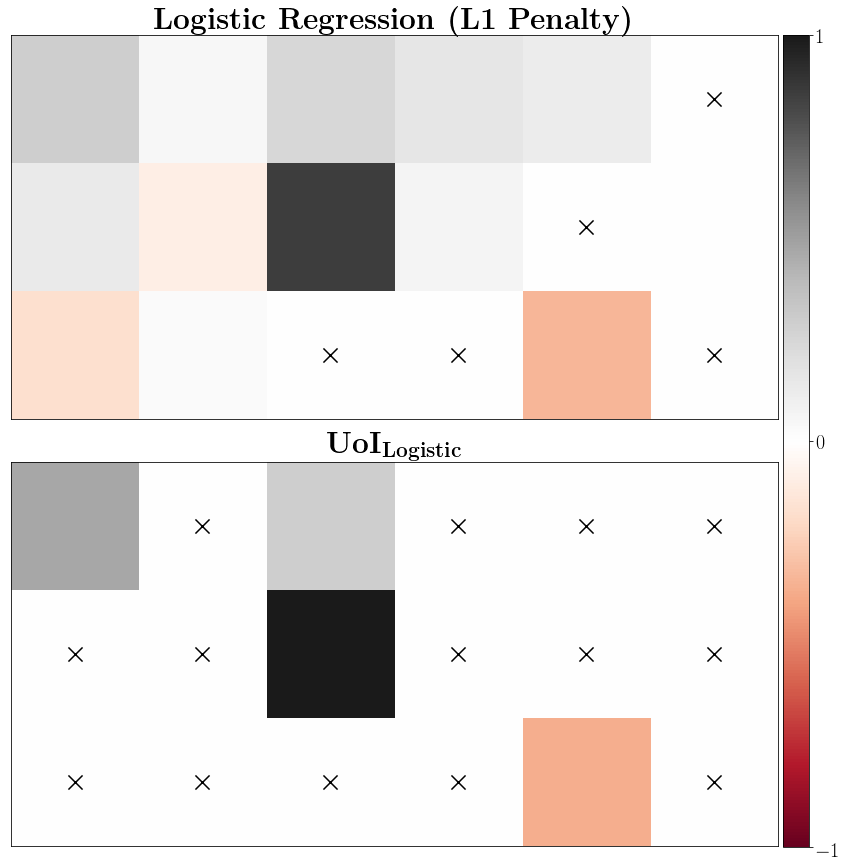

In [150]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_gp_coefs, axis=0)
uoi_coefs = np.median(uoi_gp_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((3, 6)), axis=0),
    vmin=-1, vmax=1,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 3)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}')

axes[1].imshow(
    np.flip(uoi_coefs.reshape((3, 6)), axis=0),
    vmin=-1, vmax=1,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$')

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 3)
        axes[1].scatter(x, y, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.95, 0.015, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1, 0, 1])

plt.savefig('gp_pretone_fits.pdf', bbox_inches='tight')

In [171]:
X = np.zeros((snr.n_good_trials, snr.n_good_units))
y = np.zeros(snr.n_good_trials)

for t_idx, trial_idx in enumerate(snr.good_trials):
    trial = snr.trials[trial_idx]
    y[t_idx] = trial.is_pretone_success()
    
    t_center_in = trial.t_center_in
    
    for u_idx, unit_idx in enumerate(snr.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_in) & (spike_times <= t_center_in + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=20000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_snr_coefs[fold] = logistic.coef_
    lasso_snr_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=48,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=20000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_snr_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_snr_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Incre

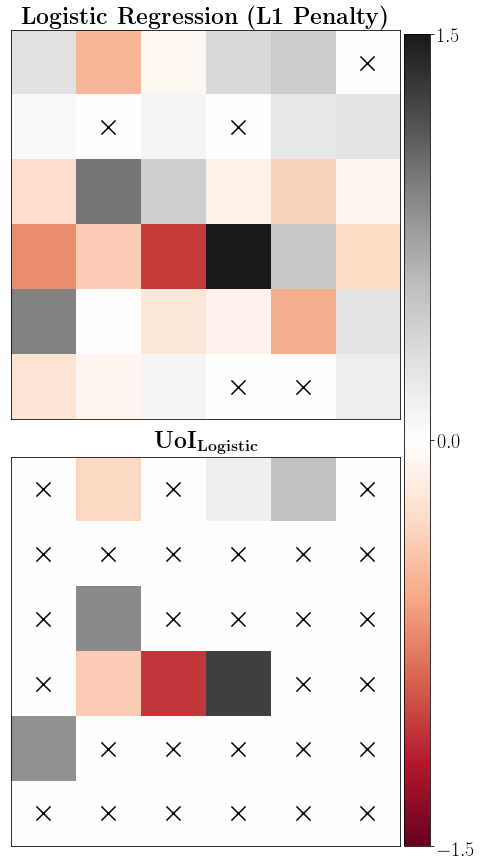

In [187]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_snr_coefs, axis=0)
uoi_coefs = np.median(uoi_snr_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}', fontsize=23)

axes[1].imshow(
    np.flip(uoi_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$', fontsize=23)

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[1].scatter(x, y, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.73, 0.016, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1.5, 0, 1.5])

plt.savefig('snr_pretone_fits.pdf', bbox_inches='tight')

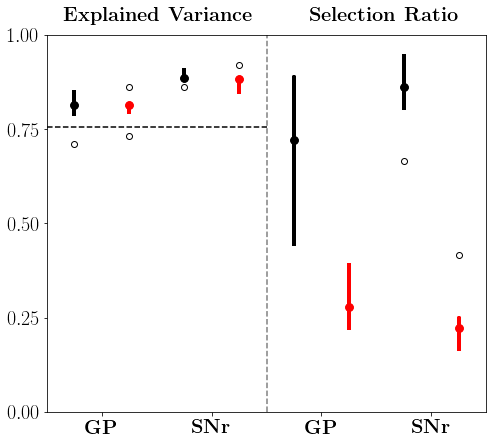

In [227]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.boxplot(
    positions=[0],
    x=lasso_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[1],
    x=uoi_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[2],
    x=lasso_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[3],
    x=uoi_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[4],
    x=np.count_nonzero(lasso_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[5],
    x=np.count_nonzero(uoi_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[6],
    x=np.count_nonzero(lasso_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[7],
    x=np.count_nonzero(uoi_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)


ax.axhline(326/432, color='k', linestyle='--', xmax=0.5)
ax.axvline(3.5, color='gray', linestyle='--')
ax.set_xlim([-0.5, 7.5])
ax.set_xticks([0.5, 2.5, 4.5, 6.5])
ax.set_xticklabels([r'\textbf{GP}', r'\textbf{SNr}', r'\textbf{GP}', r'\textbf{SNr}'])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])

plt.tight_layout()

fig.text(
    x=0.32, y=1.0, 
    s=r'\textbf{Explained Variance}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

fig.text(
    x=0.77, y=1.0, 
    s=r'\textbf{Selection Ratio}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.savefig('pretone_metrics.pdf', bbox_inches='tight')

# Predicting left vs. right trial

## Distribution between side cue and center out

In [20]:
left_trials = gp.get_successful_left_trials()
right_trials = gp.get_successful_right_trials()

In [21]:
left_dts = np.zeros(left_trials.size)
right_dts = np.zeros(right_trials.size)

for idx, trial_idx in enumerate(left_trials):
    trial = gp.trials[trial_idx]
    left_dts[idx] = trial.t_center_out - trial.t_side_cue
    
for idx, trial_idx in enumerate(right_trials):
    trial = gp.trials[trial_idx]
    right_dts[idx] = trial.t_center_out - trial.t_side_cue

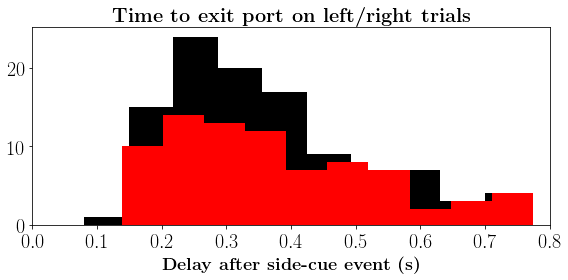

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(left_dts, color='k')
ax.hist(right_dts, color='r')
ax.set_xlim([0, 0.80])
ax.set_xlabel(r'\textbf{Delay after side-cue event (s)}', fontsize=18)
ax.set_title(r'\textbf{Time to exit port on left/right trials}', fontsize=20)
plt.tight_layout()
plt.savefig('delay_distribution_lr.pdf')

## Firing Rates in Left/Right Trial

In [9]:
left_trials = gp.get_successful_left_trials()
right_trials = gp.get_successful_right_trials()

In [10]:
sampling_rate = 500
window_length = 0.5
n_timestamps = int(sampling_rate * window_length - 1)
timestamps = np.arange(n_timestamps) / sampling_rate
sigma = 0.075

fr_left_gp = np.zeros((gp.n_good_units, left_trials.size, n_timestamps))
fr_right_gp = np.zeros((gp.n_good_units, right_trials.size, n_timestamps))
fr_left_snr = np.zeros((snr.n_good_units, left_trials.size, n_timestamps))
fr_right_snr = np.zeros((snr.n_good_units, right_trials.size, n_timestamps))

In [11]:
for ii, trial_idx in enumerate(left_trials):
    trial = gp.trials[trial_idx]
    
    side_cue = trial.t_side_cue

    bounds = (side_cue, side_cue + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_left_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_left_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

In [12]:
for ii, trial_idx in enumerate(right_trials):
    trial = snr.trials[trial_idx]
    
    center_in = trial.t_side_cue
    bounds = (center_in, center_in + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_right_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_right_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

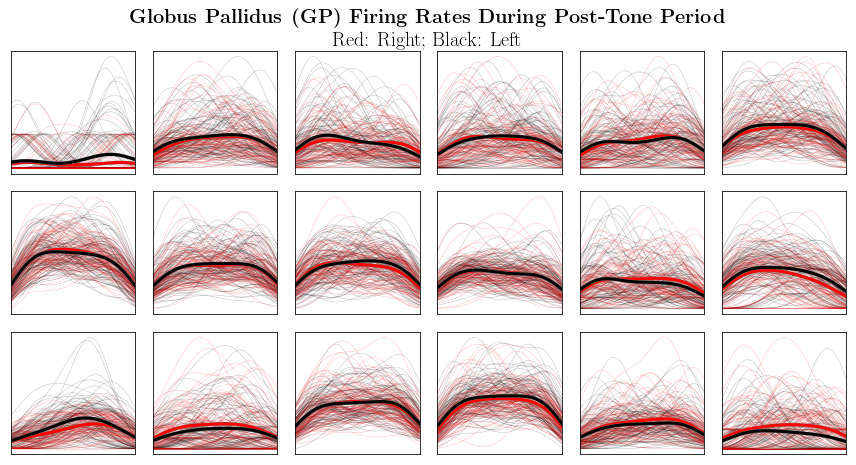

In [13]:
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_left_gp[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.25) for t_idx in range(fr_left_gp.shape[1])]
    [ax.plot(timestamps, fr_right_gp[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.25) for t_idx in range(fr_right_gp.shape[1])]
    ax.plot(timestamps, np.mean(fr_right_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_right_gp[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_left_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_left_gp[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

fig.text(
    x=0.5, y=1.02, s=r'\textbf{Globus Pallidus (GP) Firing Rates During Post-Tone Period}' '\n' r'Red: Right; Black: Left',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()
plt.savefig('gp_posttone_fr.pdf', bbox_inches='tight')
plt.show()

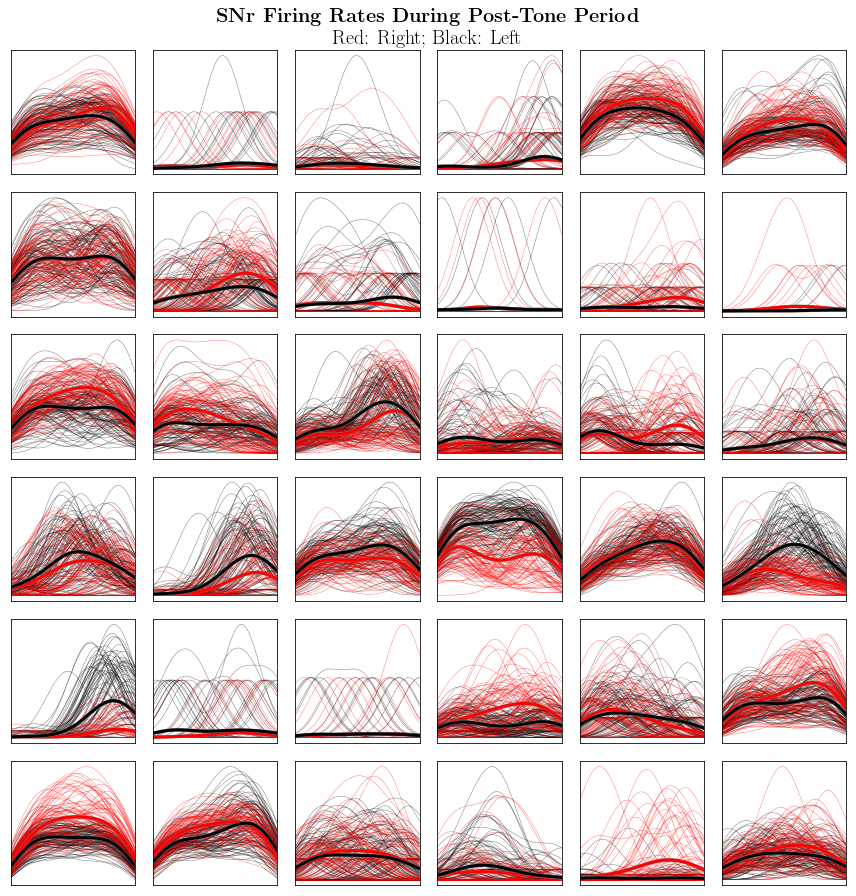

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_left_snr[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.5) for t_idx in range(fr_left_snr.shape[1])]
    [ax.plot(timestamps, fr_right_snr[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.5) for t_idx in range(fr_right_snr.shape[1])]
    ax.plot(timestamps, np.mean(fr_right_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_right_snr[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_left_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_left_snr[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

    
fig.text(
    x=0.5, y=1.01, s=r'\textbf{SNr Firing Rates During Post-Tone Period}' '\n' r'Red: Right; Black: Left',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()

plt.savefig('snr_posttone_fr.pdf', bbox_inches='tight')
plt.show()

## Logistic Regression Left/Right

In [8]:
def idx_to_xy(idx, dx, dy):
    x = idx % dx
    y = dy - 1 - (idx // dx)
    return x, y

In [9]:
valid_trials = np.sort(np.concatenate((
    gp.get_successful_left_trials(), gp.get_successful_right_trials()
)))

In [10]:
window_length = 0.50
n_folds = 5

lasso_gp_scores = np.zeros(n_folds)
lasso_gp_coefs = np.zeros((n_folds, gp.n_good_units))
uoi_gp_scores = np.zeros(n_folds)
uoi_gp_coefs = np.zeros((n_folds, gp.n_good_units))

lasso_snr_scores = np.zeros(n_folds)
lasso_snr_coefs = np.zeros((n_folds, snr.n_good_units))
uoi_snr_scores = np.zeros(n_folds)
uoi_snr_coefs = np.zeros((n_folds, snr.n_good_units))

In [21]:
print(gp.get_successful_left_trials().size)
print(gp.get_successful_right_trials().size)
print(106/186)

106
80
0.5698924731182796


In [12]:
X = np.zeros((valid_trials.size, gp.n_good_units))
y = np.zeros(valid_trials.size)

for t_idx, trial_idx in enumerate(valid_trials):
    trial = gp.trials[trial_idx]
    y[t_idx] = trial.is_successful_right()
    
    t_center_in = trial.t_center_out
    
    for u_idx, unit_idx in enumerate(gp.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_in) & (spike_times <= t_center_in + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=10000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_gp_coefs[fold] = logistic.coef_
    lasso_gp_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=100,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=10000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_gp_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_gp_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

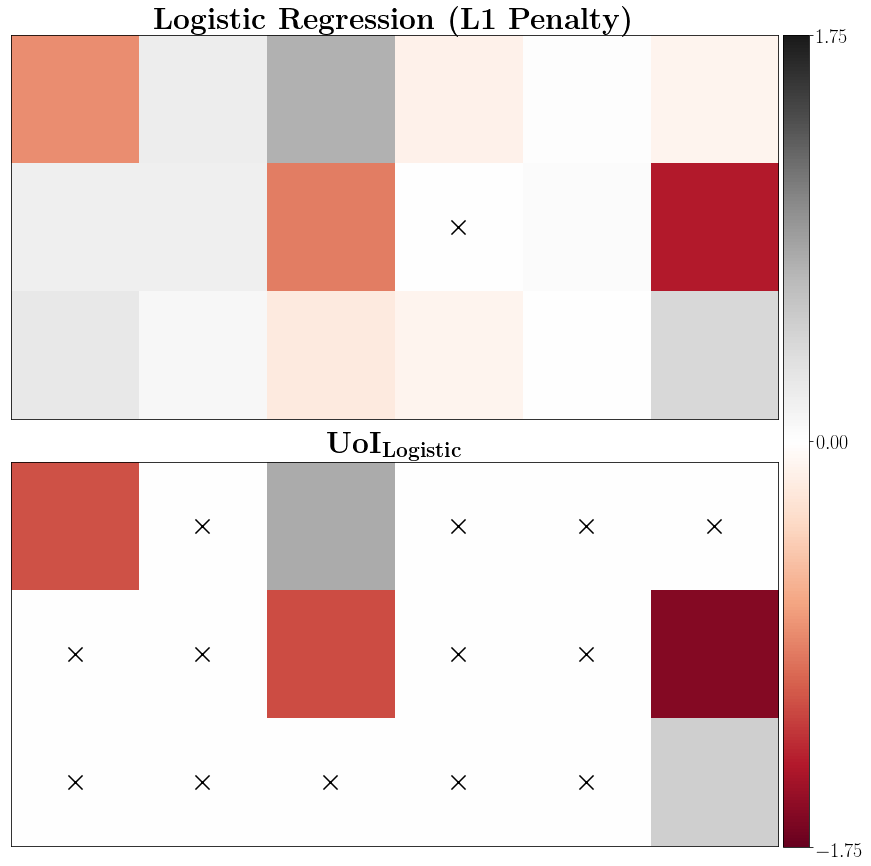

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_gp_coefs, axis=0)
uoi_coefs = np.median(uoi_gp_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((3, 6)), axis=0),
    vmin=-1.75, vmax=1.75,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 3)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}')

axes[1].imshow(
    np.flip(uoi_coefs.reshape((3, 6)), axis=0),
    vmin=-1.75, vmax=1.75,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$')

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 3)
        axes[1].scatter(x, y, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.95, 0.015, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1.75, 0, 1.75])

plt.savefig('gp_posttone_fits.pdf', bbox_inches='tight')

In [38]:
X = np.zeros((valid_trials.size, snr.n_good_units))
y = np.zeros(valid_trials.size)

for t_idx, trial_idx in enumerate(valid_trials):
    trial = snr.trials[trial_idx]
    y[t_idx] = trial.is_successful_right()
    
    t_center_out = trial.t_center_out
    
    for u_idx, unit_idx in enumerate(snr.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_out) & (spike_times <= t_center_out + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=20000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_snr_coefs[fold] = logistic.coef_
    lasso_snr_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=48,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=20000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_snr_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_snr_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

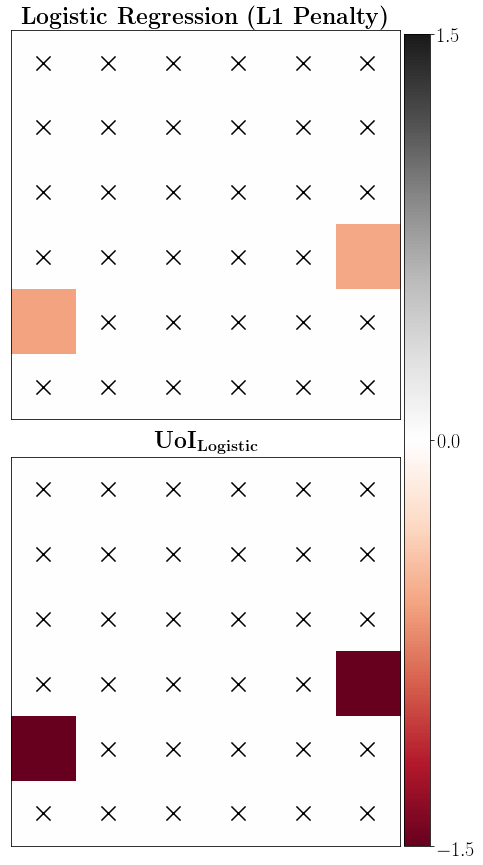

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_snr_coefs, axis=0)
uoi_coefs = np.median(uoi_snr_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}', fontsize=23)

axes[1].imshow(
    np.flip(uoi_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$', fontsize=23)

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[1].scatter(x, y, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.73, 0.016, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1.5, 0, 1.5])

plt.savefig('snr_posttone_fits.pdf', bbox_inches='tight')

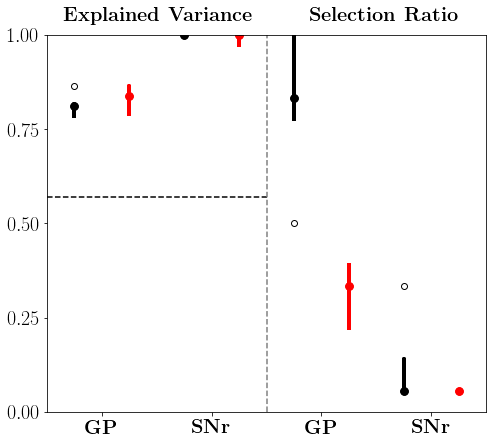

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.boxplot(
    positions=[0],
    x=lasso_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[1],
    x=uoi_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[2],
    x=lasso_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[3],
    x=uoi_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[4],
    x=np.count_nonzero(lasso_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[5],
    x=np.count_nonzero(uoi_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[6],
    x=np.count_nonzero(lasso_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[7],
    x=np.count_nonzero(uoi_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)


ax.axhline(106/186, color='k', linestyle='--', xmax=0.5)
ax.axvline(3.5, color='gray', linestyle='--')
ax.set_xlim([-0.5, 7.5])
ax.set_xticks([0.5, 2.5, 4.5, 6.5])
ax.set_xticklabels([r'\textbf{GP}', r'\textbf{SNr}', r'\textbf{GP}', r'\textbf{SNr}'])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])

plt.tight_layout()

fig.text(
    x=0.32, y=1.0, 
    s=r'\textbf{Explained Variance}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

fig.text(
    x=0.77, y=1.0, 
    s=r'\textbf{Selection Ratio}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.savefig('posttone_metrics.pdf', bbox_inches='tight')

# Stop vs. Go Trials

## Distribution between side cue and center out

In [47]:
go_trials = gp.get_successful_go_trials()
stop_trials = gp.get_successful_stop_trials()

In [48]:
go_dts = np.zeros(go_trials.size)
stop_dts = np.zeros(stop_trials.size)

for idx, trial_idx in enumerate(go_trials):
    trial = gp.trials[trial_idx]
    go_dts[idx] = trial.t_center_out - trial.t_side_cue
    
for idx, trial_idx in enumerate(stop_trials):
    trial = gp.trials[trial_idx]
    stop_dts[idx] = trial.t_center_out - trial.t_side_cue

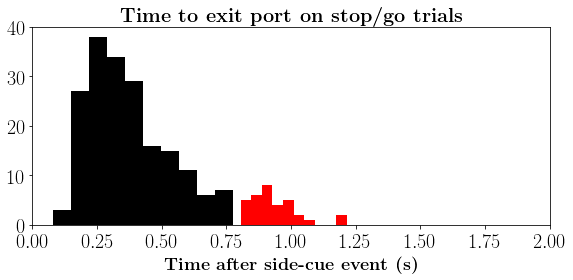

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(go_dts, color='k')
ax.hist(stop_dts, color='r')
ax.set_xlim([0, 2])
ax.set_xlabel(r'\textbf{Time after side-cue event (s)}', fontsize=18)
ax.set_title(r'\textbf{Time to exit port on stop/go trials}', fontsize=20)
plt.tight_layout()
plt.savefig('delay_distribution_sg.pdf')

## Firing Rates in Post-Tone Period

In [24]:
go_trials = gp.get_successful_go_trials()
stop_trials = gp.get_successful_stop_trials()

In [25]:
sampling_rate = 500
window_length = 0.5
n_timestamps = int(sampling_rate * window_length - 1)
timestamps = np.arange(n_timestamps) / sampling_rate
sigma = 0.075

fr_go_gp = np.zeros((gp.n_good_units, go_trials.size, n_timestamps))
fr_stop_gp = np.zeros((gp.n_good_units, stop_trials.size, n_timestamps))
fr_go_snr = np.zeros((snr.n_good_units, go_trials.size, n_timestamps))
fr_stop_snr = np.zeros((snr.n_good_units, stop_trials.size, n_timestamps))

In [26]:
for ii, trial_idx in enumerate(go_trials):
    trial = gp.trials[trial_idx]
    
    side_cue = trial.t_side_cue

    bounds = (side_cue, side_cue + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_go_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_go_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

In [27]:
for ii, trial_idx in enumerate(stop_trials):
    trial = snr.trials[trial_idx]
    
    center_in = trial.t_side_cue
    bounds = (center_in, center_in + window_length)
    
    for jj, unit_idx in enumerate(gp.good_units):
        fr_stop_gp[jj, ii, :], _ = gp.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

    for jj, unit_idx in enumerate(snr.good_units):
        fr_stop_snr[jj, ii, :], _ = snr.get_firing_rate(
            trial=trial_idx,
            unit=unit_idx,
            bounds=bounds,
            sigma=sigma)

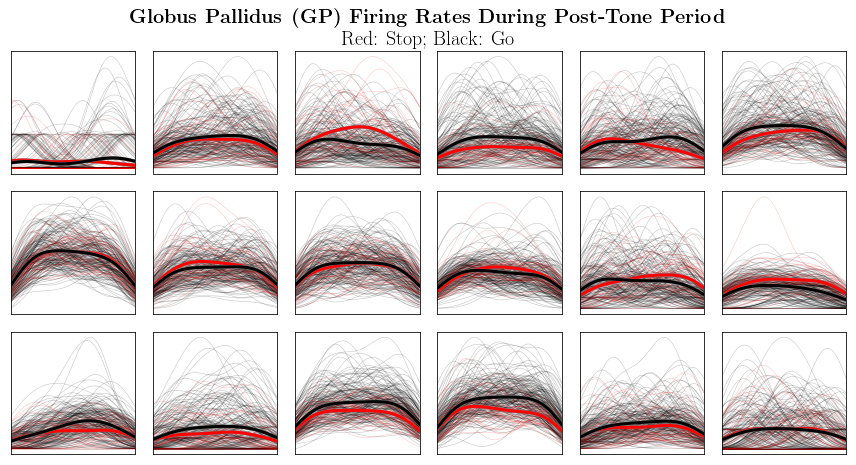

In [29]:
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_go_gp[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.25) for t_idx in range(fr_go_gp.shape[1])]
    [ax.plot(timestamps, fr_stop_gp[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.25) for t_idx in range(fr_stop_gp.shape[1])]
    ax.plot(timestamps, np.mean(fr_stop_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_stop_gp[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_go_gp[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_go_gp[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

fig.text(
    x=0.5, y=1.02, s=r'\textbf{Globus Pallidus (GP) Firing Rates During Post-Tone Period}' '\n' r'Red: Stop; Black: Go',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()
plt.savefig('gp_stopgo_fr.pdf', bbox_inches='tight')
plt.show()

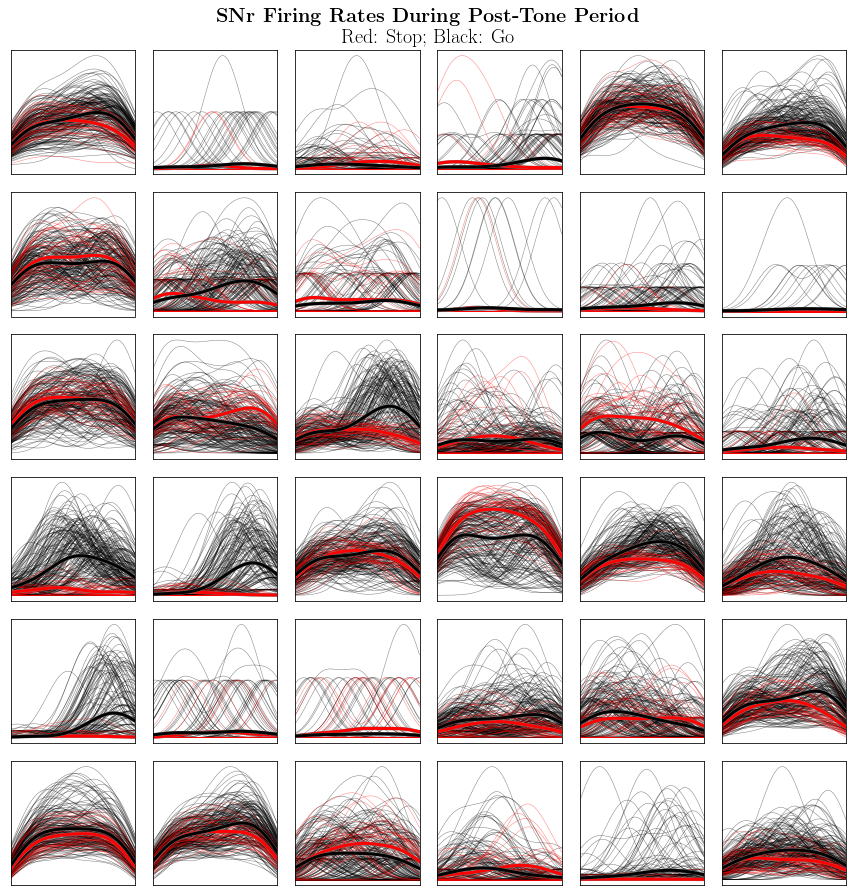

In [30]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for ax_idx, ax in enumerate(axes.ravel()):
    [ax.plot(timestamps, fr_go_snr[ax_idx, t_idx, :], color='k', linewidth=0.5, alpha=0.5) for t_idx in range(fr_go_snr.shape[1])]
    [ax.plot(timestamps, fr_stop_snr[ax_idx, t_idx, :], color='r', linewidth=0.5, alpha=0.5) for t_idx in range(fr_stop_snr.shape[1])]
    ax.plot(timestamps, np.mean(fr_stop_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_stop_snr[ax_idx], axis=0), color='r', linewidth=3, alpha=1)
    ax.plot(timestamps, np.mean(fr_go_snr[ax_idx], axis=0), color='gray', linewidth=3.5, alpha=1)
    ax.plot(timestamps, np.mean(fr_go_snr[ax_idx], axis=0), color='k', linewidth=3, alpha=1)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([timestamps[0], timestamps[-1]])

    
fig.text(
    x=0.5, y=1.01, s=r'\textbf{SNr Firing Rates During Post-Tone Period}' '\n' r'Red: Stop; Black: Go',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.tight_layout()

plt.savefig('snr_stopgo_fr.pdf', bbox_inches='tight')
plt.show()

# Logistic Regression Predicting Stop/Go

In [4]:
def idx_to_xy(idx, dx, dy):
    x = idx % dx
    y = dy - 1 - (idx // dx)
    return x, y

In [5]:
stop_trials = gp.get_successful_stop_trials()
go_trials = gp.get_successful_go_trials()

valid_trials = np.sort(np.concatenate((
    gp.get_successful_stop_trials(), gp.get_successful_go_trials()
)))

In [44]:
window_length = 0.5
n_folds = 5

lasso_gp_scores = np.zeros(n_folds)
lasso_gp_coefs = np.zeros((n_folds, gp.n_good_units))
uoi_gp_scores = np.zeros(n_folds)
uoi_gp_coefs = np.zeros((n_folds, gp.n_good_units))

lasso_snr_scores = np.zeros(n_folds)
lasso_snr_coefs = np.zeros((n_folds, snr.n_good_units))
uoi_snr_scores = np.zeros(n_folds)
uoi_snr_coefs = np.zeros((n_folds, snr.n_good_units))

In [45]:
print(stop_trials.size)
print(go_trials.size)
print(186/219)

33
186
0.8493150684931506


In [52]:
X = np.zeros((valid_trials.size, gp.n_good_units))
y = np.zeros(valid_trials.size)

for t_idx, trial_idx in enumerate(valid_trials):
    trial = gp.trials[trial_idx]
    y[t_idx] = trial.is_successful_go()
    
    t_center_out = trial.t_center_out
    
    for u_idx, unit_idx in enumerate(gp.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_out) & (spike_times <= t_center_out + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=10000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_gp_coefs[fold] = logistic.coef_
    lasso_gp_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=100,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=10000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_gp_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_gp_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

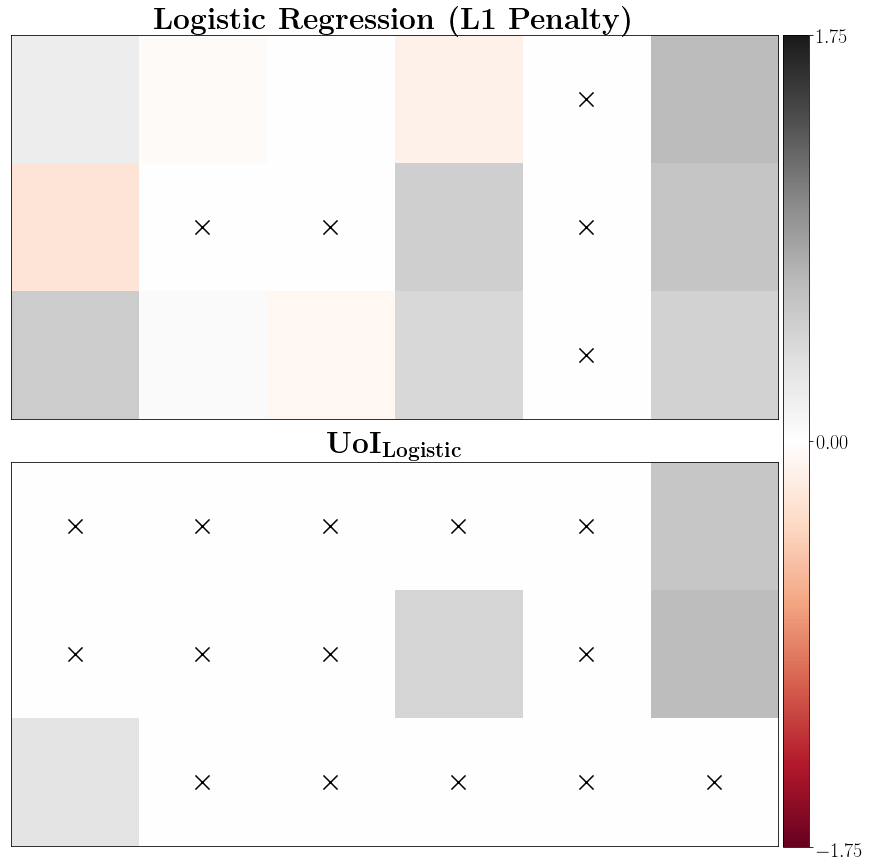

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_gp_coefs, axis=0)
uoi_coefs = np.median(uoi_gp_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((3, 6)), axis=0),
    vmin=-1.75, vmax=1.75,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 3)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}')

axes[1].imshow(
    np.flip(uoi_coefs.reshape((3, 6)), axis=0),
    vmin=-1.75, vmax=1.75,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$')

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        xplt, yplt = idx_to_xy(idx, 6, 3)
        axes[1].scatter(xplt, yplt, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.95, 0.015, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1.75, 0, 1.75])

plt.savefig('gp_stopgo_fits.pdf', bbox_inches='tight')

In [55]:
X = np.zeros((valid_trials.size, snr.n_good_units))
y = np.zeros(valid_trials.size)

for t_idx, trial_idx in enumerate(valid_trials):
    trial = snr.trials[trial_idx]
    y[t_idx] = trial.is_successful_go()
    
    t_center_out = trial.t_center_out
    
    for u_idx, unit_idx in enumerate(snr.good_units):
        spike_times = trial.spike_times[unit_idx]
        spike_count = np.count_nonzero(
            (spike_times >= t_center_out) & (spike_times <= t_center_out + window_length)
        )
        X[t_idx, u_idx] = spike_count
        
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
skf.get_n_splits(X_new, y)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y)):
    logistic = LogisticRegressionCV(
        Cs=100, fit_intercept=True, cv=10,
        penalty='l1', solver='saga',
        max_iter=20000
    )
    logistic.fit(X_new[train_idx, :], y[train_idx])
    lasso_snr_coefs[fold] = logistic.coef_
    lasso_snr_scores[fold] = logistic.score(X_new[test_idx, :], y[test_idx])
    
    uoi = UoI_L1Logistic(
        n_C=48,
        normalize=False,
        n_boots_sel=30,
        n_boots_est=30,
        selection_frac=0.8,
        estimation_frac=0.8,
        max_iter=20000)
    uoi.fit(X_new[train_idx, :], y[train_idx])
    uoi_snr_coefs[fold] = uoi.coef_
    
    logit = uoi.intercept_ + np.dot(X_new[test_idx, :], uoi.coef_.ravel())
    prob = 1./(1 + np.exp(-logit))
    predict = prob > 0.5
    uoi_snr_scores[fold] = np.count_nonzero(predict == y[test_idx])/predict.size

/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/psachdeva/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


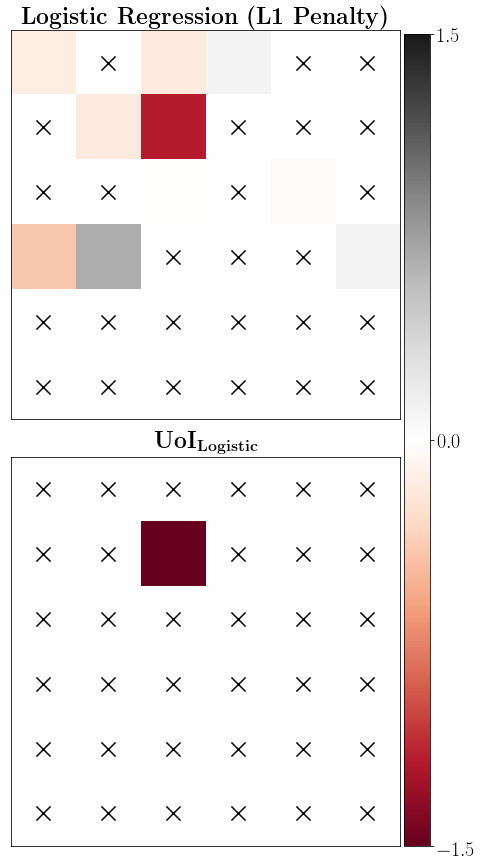

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(12,12))

lasso_coefs = np.median(lasso_snr_coefs, axis=0)
uoi_coefs = np.median(uoi_snr_coefs, axis=0)

img = axes[0].imshow(
    np.flip(lasso_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[0].set_xticks([])
axes[0].set_yticks([])
for idx, coef in enumerate(lasso_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[0].scatter(x, y, marker='x', color='k', s=200)
axes[0].set_title(r'\textbf{Logistic Regression (L1 Penalty)}', fontsize=23)

axes[1].imshow(
    np.flip(uoi_coefs.reshape((6, 6)), axis=0),
    vmin=-1.5, vmax=1.5,
    cmap=plt.get_cmap('RdGy'))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title(r'\textbf{UoI}$_{\textbf{Logistic}}$', fontsize=23)

for idx, coef in enumerate(uoi_coefs):
    if coef == 0:
        x, y = idx_to_xy(idx, 6, 6)
        axes[1].scatter(x, y, marker='x', color='k', s=200)

plt.tight_layout()
cax = fig.add_axes([0.73, 0.016, 0.03, 0.94])

cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([-1.5, 0, 1.5])

plt.savefig('snr_stopgo_fits.pdf', bbox_inches='tight')

In [51]:
print(np.median(uoi_snr_scores))
print(np.median())

array([0.84444444, 0.88636364, 0.90909091, 0.86046512, 0.93023256])

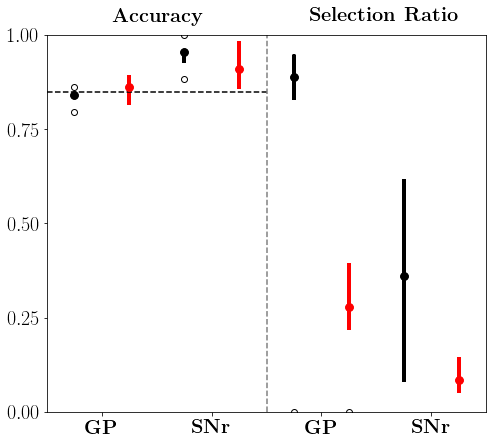

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.boxplot(
    positions=[0],
    x=lasso_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[1],
    x=uoi_gp_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[2],
    x=lasso_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[3],
    x=uoi_snr_scores,
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[4],
    x=np.count_nonzero(lasso_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[5],
    x=np.count_nonzero(uoi_gp_coefs, axis=1)/lasso_gp_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)

ax.boxplot(
    positions=[6],
    x=np.count_nonzero(lasso_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'k'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'k'},
    whiskerprops={'linewidth': 4, 'color': 'k'}
)

ax.boxplot(
    positions=[7],
    x=np.count_nonzero(uoi_snr_coefs, axis=1)/lasso_snr_coefs.shape[1],
    widths=0,
    boxprops={'linewidth': 4, 'color': 'r'},
    medianprops={'marker': '.', 'markersize': 15, 'color': 'r'},
    whiskerprops={'linewidth': 4, 'color': 'r'},
)


ax.axhline(186/(186+33), color='k', linestyle='--', xmax=0.5)
ax.axvline(3.5, color='gray', linestyle='--')
ax.set_xlim([-0.5, 7.5])
ax.set_xticks([0.5, 2.5, 4.5, 6.5])
ax.set_xticklabels([r'\textbf{GP}', r'\textbf{SNr}', r'\textbf{GP}', r'\textbf{SNr}'])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])

plt.tight_layout()

fig.text(
    x=0.32, y=1.0, 
    s=r'\textbf{Accuracy}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

fig.text(
    x=0.77, y=1.0, 
    s=r'\textbf{Selection Ratio}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20
)

plt.savefig('stopgo_metrics.pdf', bbox_inches='tight')

In [61]:
gp.get_successful_go_trials().size

186